In [57]:
from collections import Counter

%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [58]:
transactions = pd.read_csv("purchases.txt", delimiter="\t", header=None)

transactions.columns = ['cust_id', 'purchase_amt', 'date']

transactions['year'] = transactions['date'].apply(lambda x: x[:4])
transactions['purchase_amt'] = transactions['purchase_amt'].apply(lambda x: float(x))

transactions.head()

,cust_id,purchase_amt,date,year
0,760,25.0,2009-11-06,2009
1,860,50.0,2012-09-28,2012
2,1200,100.0,2005-10-25,2005
3,1420,50.0,2009-07-09,2009
4,1940,70.0,2013-01-25,2013


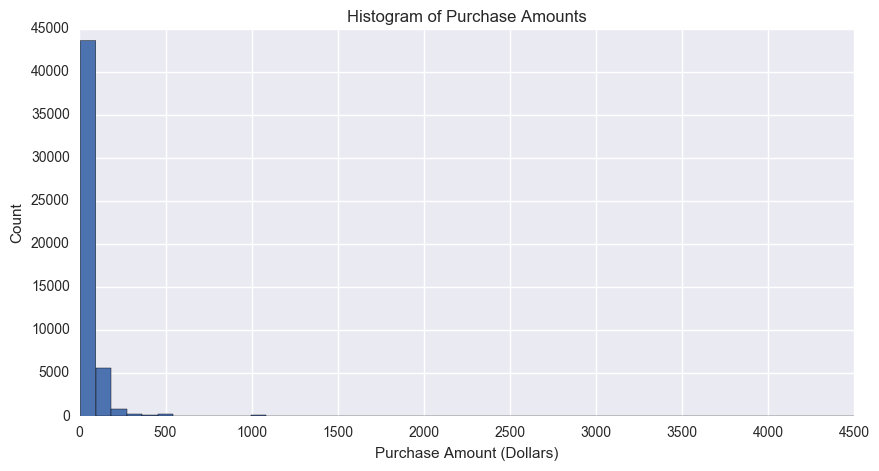

In [59]:
fig, axs = plt.subplots(1,1, figsize = (10,5))

axs.hist(transactions['purchase_amt'], bins=50);
axs.set_title('Histogram of Purchase Amounts');

axs.set_xlabel("Purchase Amount (Dollars)");
axs.set_ylabel("Count");

In [60]:
transactions = transactions.groupby(['cust_id', 'year'])['purchase_amt'].sum().reset_index()
purchase_amts = transactions['purchase_amt']
purchase_amts.mean()

71.03911622114485

In [61]:
boolean_matrix = pd.crosstab(transactions.cust_id, [transactions.year], rownames=['cust_id'], colnames=['year'])
boolean_matrix = boolean_matrix.applymap(lambda x: 1 if x>0 else 0)

In [62]:
boolean_matrix_restricted = boolean_matrix[boolean_matrix['2005'] == 1]
boolean_matrix_restricted.head()

year,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
cust_id,,,,,,,,,,,
10,1,0,0,0,0,0,0,0,0,0,0
80,1,0,1,0,1,0,1,0,1,1,1
90,1,1,1,1,1,1,1,1,1,0,0
130,1,0,1,0,0,0,0,0,0,0,0
190,1,1,1,1,1,0,0,0,0,0,0


In [63]:
recency_matrix, RFM_matrix = build_recency_and_RFM_matrix(boolean_matrix_restricted, transactions)

In [64]:
frequencies = []

for row in RFM_matrix:
    for cell_value in row:
        frequencies.append(cell_value[1])

In [65]:
recency_df = pd.DataFrame(np.array(recency_matrix))

recency_df.index = boolean_matrix_restricted.index
recency_df.columns = boolean_matrix_restricted.columns

recency_df.head()

year,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
cust_id,,,,,,,,,,,
10,0,1,2,3,4,5,6,7,8,9,10
80,0,1,0,1,0,1,0,1,0,0,0
90,0,0,0,0,0,0,0,0,0,1,2
130,0,1,0,1,2,3,4,5,6,7,8
190,0,0,0,0,0,1,2,3,4,5,6


In [66]:
total_at_recency_dict = {}
total_transition_recencies_dict = {}

In [67]:
# dictionary mapping RFM tuples to numbered states

RFM_states = {(1, 1, 1): 1,
              (1, 1, 2): 2,
              (1, 1, 3): 3,
              (1, 2, 1): 4,
              (1, 2, 2): 5,
              (1, 2, 3): 6,
              (2, 1, 1): 7,
              (2, 1, 2): 8,
              (2, 1, 3): 9,
              (2, 2, 1): 10,
              (2, 2, 2): 11,
              (2, 2, 3): 12,
              (3, 1, 1): 13,
              (3, 1, 2): 14,
              (3, 1, 3): 15,
              (3, 2, 1): 16,
              (3, 2, 2): 17,
              (3, 2, 3): 18}

In [68]:
state_matrix = convert_to_state_matrix(RFM_matrix, RFM_states)

state_df = pd.DataFrame(np.array(state_matrix))

state_df.columns = boolean_matrix_restricted.columns
state_df.index = boolean_matrix_restricted.index

state_df.head()

year,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
cust_id,,,,,,,,,,,
10,6,12,12,12,12,12,18,18,18,18,18
80,5,11,4,10,4,10,4,10,4,1,1
90,4,4,4,4,4,1,1,1,1,7,7
130,5,11,4,10,10,10,10,10,16,16,16
190,5,4,6,4,4,10,10,10,10,10,16


In [69]:
# build transition matrix for recency
for recency_score in range(11):
    total_at_recency = 0
    
    total_transition_states_observed = Counter()
    
    for year in state_df.columns:
        # no data for 2016 so leave 2015 out
        if year == '2015':
            break

        # reduce dataframe to people who were in this state this year
        this_recency_this_year = recency_df[recency_df[year] == recency_score]
        
        # total number of people observed in this state this year
        total_this_recency_this_year = this_recency_this_year.shape[0]
        total_at_recency += total_this_recency_this_year
        
        # get count of states observed the next year
        next_year = str(int(year) + 1)
        
        observed_recencies_next_year = Counter(list(this_recency_this_year[next_year]))

        total_transition_states_observed += observed_recencies_next_year
        
    total_at_recency_dict[recency_score] = total_at_recency
    total_transition_recencies_dict[recency_score] = total_transition_states_observed

In [70]:
# build recency transition matrix
recency_transition_matrix = np.zeros((11,11))

for i in range(10):
    for j in range(11):
        transition_prob = total_transition_recencies_dict[i][j] / total_at_recency_dict[i]
        
        recency_transition_matrix[i, j] = transition_prob

In [71]:
pd.DataFrame(recency_transition_matrix)

,0,1,2,3,4,5,6,7,8,9,10
0,0.716090,0.28391,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.329261,0.00000,0.670739,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.137864,0.00000,0.000000,0.862136,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.086849,0.00000,0.000000,0.000000,0.913151,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.074963,0.00000,0.000000,0.000000,0.000000,0.925037,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.035842,0.00000,0.000000,0.000000,0.000000,0.000000,0.964158,0.000000,0.000000,0.000000,0.000000
6,0.057732,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.942268,0.000000,0.000000,0.000000
7,0.041162,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.958838,0.000000,0.000000
8,0.009585,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.990415,0.000000
9,0.020492,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.979508


In [72]:
frequencies = []

for row in RFM_matrix:
    for cell_value in row:
        frequencies.append(cell_value[1])

In [73]:
# some useful functions

def build_recency_and_RFM_matrix(boolean_matrix, transactions): 
    '''
    INPUT: boolean matrix with users as rows, years as columns. 
    cell value 1 if user made a purchase in that year.
    cell value 0 if user made no purchase in that year.
    
    OUTPUT:
    recency matrix: matrix showing user's recency score for a given year.
    RFM matrix: matrix showing user's RFM tuple for a given year
    '''
    
    recency_matrix = []
    RFM_matrix = []
    
    for row_num, boolean_row in enumerate(boolean_matrix.values):
        cust_id = int(boolean_matrix.index[row_num])

        frequency = 0 
        recency = 0
        
        recency_row = []
        RFM_row = []

        for col_num, cell_value in enumerate(boolean_row):
            year = boolean_matrix.columns[col_num]

            if cell_value == 1:
                transactions_by_cust = transactions[transactions['cust_id']==cust_id]
                transactions_by_cust_by_year = transactions_by_cust[transactions_by_cust['year'] == year]
                
                monetary = float(transactions_by_cust_by_year['purchase_amt'])
                
                frequency += 1
                recency = 0

            else:
                recency+=1
            
            recency_row.append(recency)
            RFM_row.append((recency, frequency, monetary))
        
        recency_matrix.append(recency_row)
        RFM_matrix.append(RFM_row)
        
    return recency_matrix, RFM_matrix

def convert_to_discrete_tuple(continuous_tuple):
    '''
    INPUT: continuous RFM tuple corresponding to a user
    OUTPUT: discrete tuple according to the segementation we defined
    '''
    
    if continuous_tuple[0] <= 0:
        R = 1
        
    elif continuous_tuple[0] < 6:
        R = 2
        
    else:
        R = 3
        
    if continuous_tuple[1] > 5:
        F = 1
        
    else:
        F = 2
        
    if continuous_tuple[2] > 50:
        M = 1
        
    elif continuous_tuple[2] > 30 or continuous_tuple[2] == 50:
        M = 2
        
    else:
        M = 3
    
    return R, F, M

def convert_to_state_matrix(continuous_tuple_matrix, RFM_states):
    '''
    INPUT:
    matrix of RFM tuples for each user/year
    dictionary mapping RFM tuples to state numbers
    
    OUTPUT:
    matrix of states for each user/year
    '''

    new_matrix = []
    
    for row in continuous_tuple_matrix:
        new_row = []
        
        for continuous_tuple in row:
            discrete_tuple = convert_to_discrete_tuple(continuous_tuple)
            
            state = RFM_states[discrete_tuple]
            
            new_row.append(state)
            
        new_matrix.append(new_row)
        
    return new_matrix
            
state_matrix = convert_to_state_matrix(RFM_matrix, RFM_states)

In [74]:
from collections import Counter

# dictionary that maps states to the total customers observed in that state
# key: state number
# value: integer giving total number
total_in_state_dict = {}

# dictionary that maps states to the distribution of states the year following
# key: state number
# value: counter of states the following year
total_transition_states_dict = {}

In [75]:
# build transition matrix for RFMs
for state in range(1, 19):
    total_in_state = 0
    
    total_transition_states_observed = Counter()
    
    for year in state_df.columns:
        # no data for 2016 so leave 2015 out
        if year == '2015':
            break

        # reduce dataframe to people who were in this state this year
        this_state_this_year = state_df[state_df[year] == state]
        
        # total number of people observed in this state this year
        total_this_state_this_year = this_state_this_year.shape[0]
        total_in_state += total_this_state_this_year
        
        # get count of states observed the next year
        next_year = str(int(year) + 1)
        
        observed_states_next_year = Counter(list(this_state_this_year[next_year]))

        total_transition_states_observed += observed_states_next_year
        
    total_in_state_dict[state] = total_in_state
    total_transition_states_dict[state] = total_transition_states_observed
    
total_in_state_dict

{1: 862,
 2: 419,
 3: 477,
 4: 1708,
 5: 813,
 6: 1818,
 7: 173,
 8: 102,
 9: 137,
 10: 1345,
 11: 652,
 12: 2289,
 13: 0,
 14: 0,
 15: 0,
 16: 393,
 17: 218,
 18: 844}

In [76]:
total_transition_states_dict

{1: Counter({1: 659, 2: 47, 3: 34, 7: 122}),
 2: Counter({1: 67, 2: 256, 3: 30, 8: 66}),
 3: Counter({1: 24, 2: 46, 3: 302, 9: 105}),
 4: Counter({1: 177, 2: 23, 3: 9, 4: 817, 5: 111, 6: 100, 10: 471}),
 5: Counter({1: 18, 2: 68, 3: 13, 4: 149, 5: 235, 6: 97, 11: 233}),
 6: Counter({1: 16, 2: 23, 3: 114, 4: 115, 5: 100, 6: 716, 12: 734}),
 7: Counter({1: 25, 2: 4, 3: 6, 7: 138}),
 8: Counter({1: 8, 2: 9, 3: 4, 8: 81}),
 9: Counter({1: 4, 2: 2, 3: 19, 9: 112}),
 10: Counter({1: 25, 2: 4, 3: 1, 4: 160, 5: 31, 6: 37, 10: 920, 16: 167}),
 11: Counter({1: 6, 2: 5, 3: 5, 4: 48, 5: 28, 6: 27, 11: 457, 17: 76}),
 12: Counter({1: 1, 2: 7, 3: 22, 4: 59, 5: 44, 6: 230, 12: 1631, 18: 295}),
 13: Counter(),
 14: Counter(),
 15: Counter(),
 16: Counter({4: 13, 6: 4, 16: 376}),
 17: Counter({4: 3, 5: 4, 6: 1, 17: 210}),
 18: Counter({4: 5, 5: 1, 6: 22, 18: 816})}

In [77]:
# build transition matrix
RFM_transition_matrix = np.zeros((18,18))

for i in range(1,18):
    for j in range(1,18):
        # absorbtion states
        if i >= 13 and i == j:
            transition_prob = 1
        elif i >= 13 and i != j:
            transition_prob = 0
        else:
            transition_prob = total_transition_states_dict[i][j] / total_in_state_dict[i]
        
        RFM_transition_matrix[i-1, j-1] = transition_prob

In [78]:
pd.DataFrame(RFM_transition_matrix)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0.764501,0.054524,0.039443,0.000000,0.000000,0.000000,0.141531,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0
1,0.159905,0.610979,0.071599,0.000000,0.000000,0.000000,0.000000,0.157518,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0
2,0.050314,0.096436,0.633124,0.000000,0.000000,0.000000,0.000000,0.000000,0.220126,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0
3,0.103630,0.013466,0.005269,0.478337,0.064988,0.058548,0.000000,0.000000,0.000000,0.275761,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0
4,0.022140,0.083641,0.015990,0.183272,0.289053,0.119311,0.000000,0.000000,0.000000,0.000000,0.286593,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0
5,0.008801,0.012651,0.062706,0.063256,0.055006,0.393839,0.000000,0.000000,0.000000,0.000000,0.000000,0.403740,0.0,0.0,0.0,0.000000,0.000000,0.0
6,0.144509,0.023121,0.034682,0.000000,0.000000,0.000000,0.797688,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0
7,0.078431,0.088235,0.039216,0.000000,0.000000,0.000000,0.000000,0.794118,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0
8,0.029197,0.014599,0.138686,0.000000,0.000000,0.000000,0.000000,0.000000,0.817518,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0
9,0.018587,0.002974,0.000743,0.118959,0.023048,0.027509,0.000000,0.000000,0.000000,0.684015,0.000000,0.000000,0.0,0.0,0.0,0.124164,0.000000,0.0


In [79]:
# build state matrices for all customers that started after 2005

years = ['2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014']

boolean_matrix_test = boolean_matrix.copy()

state_dataframes = []

for year in years:
    no_purchase_first_year = boolean_matrix_test[boolean_matrix_test[year] == 0]
    first_purchase_next_year = no_purchase_first_year[no_purchase_first_year[str(int(year)+1)] == 1]
    first_purchase_next_year.drop(year, axis=1, inplace=True)
    
    recency_matrix_here, RFM_matrix_here = build_recency_and_RFM_matrix(first_purchase_next_year, transactions)
    state_matrix_here = convert_to_state_matrix(RFM_matrix_here, RFM_states)
    
    state_df_here = pd.DataFrame(state_matrix_here)
    state_df_here.columns = first_purchase_next_year.columns
    state_df_here.index = first_purchase_next_year.index
    
    state_dataframes.append(state_df_here)
    
    boolean_matrix_test.drop(year, axis=1, inplace=True)

/Users/justw/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [80]:
initial_counter = Counter(state_df['2015'])

for individual_state_df in state_dataframes:
    individual_counter = Counter(individual_state_df['2015'])
    
    initial_counter += individual_counter

In [81]:
# build starting state vector

starting_state = []

for i in range(1, 19):
    if i in initial_counter:
        starting_state.append(starting_state_counts[i])
        
    else:
        starting_state.append(0)
    
starting_state = np.array(starting_state)

NameError: name 'starting_state_counts' is not defined

In [ ]:
starting_state

In [ ]:
new_customer_state_counts = Counter(state_df['2005'])

total_new_customers = [state_df['2005'].count()]

for individual_state_df in state_dataframes:
    new_customer_state_counts += Counter(individual_state_df[individual_state_df.columns[0]])
    
    total_new_customers.append(individual_state_df.shape[0])

average_new_customers = np.mean(total_new_customers)//1

new_customer_state_dist = {}

for state, state_count in new_customer_state_counts.items():
    new_customer_state_dist[state] = state_count/np.sum(total_new_customers)
    
new_customer_state_dist

new_state_vector_each_year = np.zeros(18)
new_state_vector_each_year[3] = average_new_customers*new_customer_state_dist[4]//1
new_state_vector_each_year[4] = average_new_customers*new_customer_state_dist[5]//1
new_state_vector_each_year[5] = average_new_customers*new_customer_state_dist[6]//1

new_state_vector_each_year

In [ ]:
# build the reward vector

avg_purchase_amt = purchase_amts.mean()

reward_vector = np.zeros(18)

for i in range(6):
    reward_vector[i] = avg_purchase_amt - 25
    
for i in range(6, 12):
    reward_vector[i] = - 25
    
for i in range(12, 18):
    reward_vector[i] = 0

In [ ]:
I_18 = np.identity(18)

CLV = (np.linalg.inv(I_18 - (1+d)**(-1)*RFM_transition_matrix)).dot(reward_vector)

CLV.reshape(len(CLV),1)

In [ ]:
# without policy

revenue_no_policy = []

total_reward = reward_vector*(((1+d)**-1)*RFM_transition_matrix).dot(starting_state)+new_state_vector_each_year
new_state = starting_state.copy()

revenue_no_policy.append(np.sum(total_reward))

for i in range(9):
    new_state = (((1+d)**-1)*RFM_transition_matrix).dot(new_state)+new_state_vector_each_year
    reward_this_year = reward_vector*new_state
    
    revenue_no_policy.append(np.sum(reward_this_year))
    
    total_reward += reward_this_year
    
revenue_no_policy

In [ ]:
np.sum(revenue_no_policy)

In [ ]:
for year, rev in enumerate(revenue_no_policy, 2016):
    print(str(year) + "\t" + str(rev))

In [ ]:
# with policy

revenue_with_policy = []

reward_vector_with_policy = reward_vector.copy()

# set all the negative CLVs to zero
reward_vector_with_policy[8:] = 0

total_reward = reward_vector_with_policy*(((1+d)**-1)*RFM_transition_matrix).dot(starting_state)+new_state_vector_each_year
new_state = starting_state.copy()

revenue_with_policy.append(np.sum(total_reward))

for i in range(9):
    new_state = (((1+d)**-1)*RFM_transition_matrix).dot(new_state)+new_state_vector_each_year
    reward_this_year = reward_vector_with_policy*new_state
    
    revenue_with_policy.append(np.sum(reward_this_year))
    
    total_reward += reward_this_year
    
money = []
    
for year, rev in enumerate(revenue_with_policy, 2016):
    print(str(year) + "\t" + str(rev))
    money.append(str(year) + "\t" + str(rev))
    


In [ ]:
fig, axs = plt.subplots(1,1, figsize = (10,5))

total_purchases = boolean_matrix_restricted.apply(lambda x: sum(x), axis=1)

axs.hist(total_purchases, bins=11)

axs.set_title("Histogram of Total Purchases")
axs.set_xlabel("Total Purchases Made")
axs.set_ylabel("Count")

In [ ]:
np.sum(revenue_with_policy)

In [ ]:
reward_vector.reshape(18, 1)

In [ ]:
CLV.reshape(18,1)

In [ ]:
np.sum(new_state_vector_each_year)